# R Homework Example 1

In this example, you will first read in the American Community Survey Public-Use Microdata to examine income distributions among workers with a Ph.D. degree. This example uses a survey data source similar to what you will use in the ADRF.

**<span style = "color:green">If you have not yet watched the "Introduction to Jupyter Notebooks" video, watch it before you proceed!</span>**

**NOTE: When you open a notebook, make sure you run each cell containing code from the beginning. Since the code we're writing builds on everything written before, if you don't make sure to run everything from the beginning, some things may not work.**

**Note, if you're running this on your personal computer, you will need to install packages beforehand, but if you're on the ADRF, the packages are installed already**

_install.packages(c("tidyverse", "car"))_

In [1]:
library(tidyverse)
library(car)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




### Read in Census American Community Survey Microdata

In this workbook, we will be using 2019 American Community Survey Public Use Microdata (PUMS). 
These are public-use data sets containing information about responses to the Census Bureau American Community Survey. Information about the ACS project can be found at [https://www.census.gov/programs-surveys/acs](https://www.census.gov/programs-surveys/acs). 

We will be using the ACS PUMS dataset for Texas and California in our examples in this workbook.

You can find more information about the ACS datasets [here](https://www.census.gov/programs-surveys/acs/microdata/access.2019.html) and the Codebook for the data [here](https://raw.githubusercontent.com/coreysparks/data/master/pums_vars.csv).


In [2]:
census <- read_csv(url("https://github.com/coreysparks/r_courses/blob/master/data/pums_tx_ca_2019.csv?raw=true"), show_col_types = F)

In [3]:
head(census)

SERIALNO,SPORDER,WGTP,PWGTP,WAGP,AGEP,ST,SCHL,SEX,ESR,...,OCCP,RAC1P,ST_label,SCHL_label,SEX_label,ESR_label,FOD1P_label,HISP_label,OCCP_label,RAC1P_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,...,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2019GQ0000004,1,0,67,0,25,48,12,1,6,...,0009,1,Texas/TX,Grade 9,Male,Not in labor force,NA,Mexican,NA,White alone
2019GQ0000013,1,0,28,6000,18,06,16,2,6,...,4110,1,California/CA,Regular high school diploma,Female,Not in labor force,NA,Not Spanish/Hispanic/Latino,EAT-Waiters And Waitresses,White alone
2019GQ0000043,1,0,43,7200,19,48,19,1,1,...,4251,1,Texas/TX,"1 or more years of college credit, no degree",Male,"Civilian employed, at work",NA,Not Spanish/Hispanic/Latino,CLN-Landscaping And Groundskeeping Workers,White alone
2019GQ0000055,1,0,4,9800,21,06,19,1,1,...,6120,8,California/CA,"1 or more years of college credit, no degree",Male,"Civilian employed, at work",NA,Mexican,FFF-Forest And Conservation Workers,Some Other Race alone
2019GQ0000064,1,0,81,0,54,06,16,2,6,...,0009,1,California/CA,Regular high school diploma,Female,Not in labor force,NA,Not Spanish/Hispanic/Latino,NA,White alone
2019GQ0000115,1,0,19,0,55,48,16,1,6,...,3655,8,Texas/TX,Regular high school diploma,Male,Not in labor force,NA,Mexican,HLS-Other Healthcare Support Workers,Some Other Race alone


## Variables we will use in this example
In this example and homework we will work with a few of the variables in this data. 

#### WAGP = Annual Wages
#### SEX = Respondent's self idenfied sex
#### SCHL = Respondent's self idenfied educational attainment
#### ESR = Respondent's self idenfied employment status
#### HISP = Respondent's self idenfied Hispanic ethnicity
#### RAC1P = Respondent's self idenfied race
#### ST = Respondent's state of residence

Specific codes and response options can be found in the codebook

# Basic visualization using ggplot and dplyr

The R packages dplyr and ggplot work very well together, with dplyr being used to process and summarize data and ggplot being used to visualize the summaries.

### Recoding variables
One common task that we have to do when using microdata, like we have in the ADRF, is to recode variables. There many ways to do this, I like the `car` package as its syntax is very approachable, but you could easily do this using `ifelse` or `dplyr::case_when` within a `mutate()` step. Here, I show how to use the `car::Recode()` function within a `mutate` step. I also insert comments using the # key to show what is being done in each step.

**NOTE** `!=` stands for *not equal*, and `==` is R's way of saying *exactly equivalent*

In [4]:
library(car)
census_sub <- census %>%
    filter(ESR %in% c(1,2),  #select people who are employed
          WAGP !=0 & is.na(WAGP)!=T, #select people with recorded wages
          SCHL == 24)%>% # select only doctoral recipients
    mutate(sex2 = Recode (SEX, recodes = "1='Male'; 2='Female' "), 
              as.factor=TRUE) #create new sex variable with labels instead of numbers

census_sub%>%
    select(sex2, WAGP)%>%
    head()

sex2,WAGP
<chr>,<dbl>
Male,90000
Male,25000
Male,90000
Male,68000
Female,120000
Male,118000


Now we can summarize the wage variable by sex, here we calculate the median wage for men and women.  You could use the `mean()` function to calculate averages instead.

In [5]:
census_sub%>%
    group_by(sex2)%>% #group_by splits the data into groups based on the variable(s) shown, you can specify more than one
    summarize(median_inc = median(WAGP, na.rm=TRUE)) #na.rm removes missing values before calculation

sex2,median_inc
<chr>,<dbl>
Female,90500
Male,120000


Likewise, we can put this summary directly into a ggplot

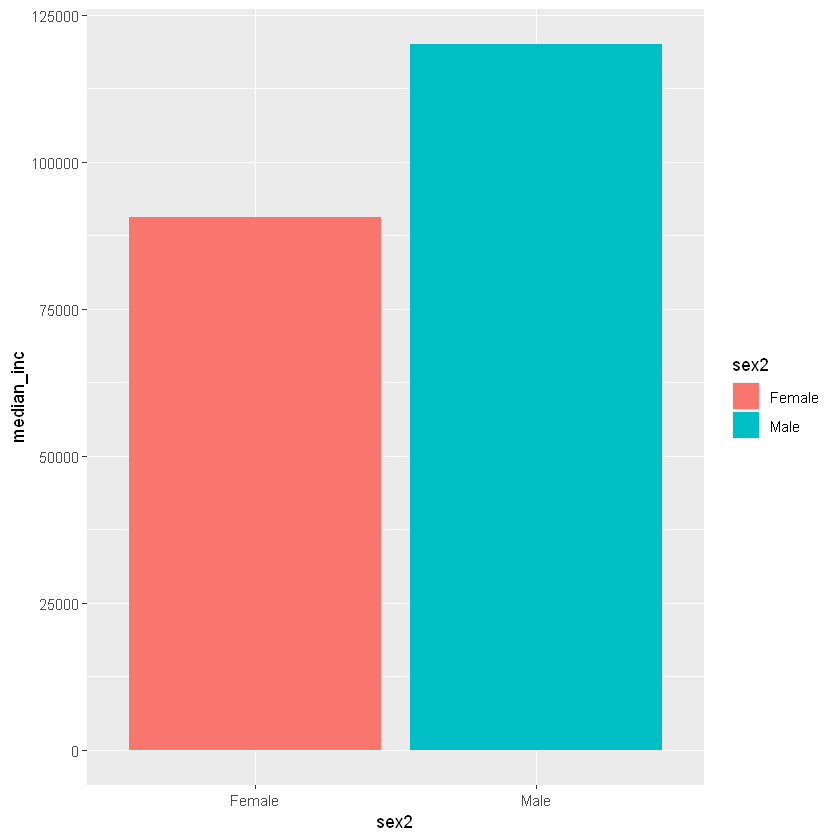

In [6]:
library(ggplot2)
census_sub%>%
    group_by(sex2)%>%
    summarize(median_inc = median(WAGP, na.rm=TRUE))%>%
ggplot(mapping = aes(fill=sex2, x=sex2, y=median_inc))+
    geom_col(position ="dodge")

### Histograms by group

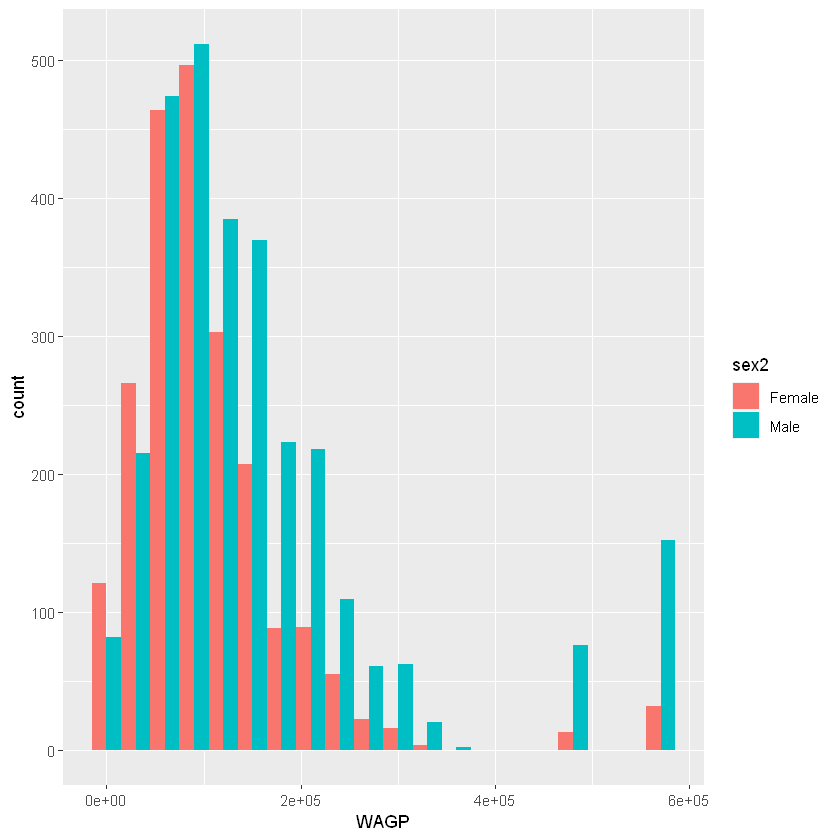

In [7]:
census_sub%>%
    ggplot(mapping = aes(fill=sex2, group=sex2, x=WAGP))+
    geom_histogram(position="dodge", bins=20) #position="dodge" plots the lines next to each other

Which is pretty ugly, the density plot may look better

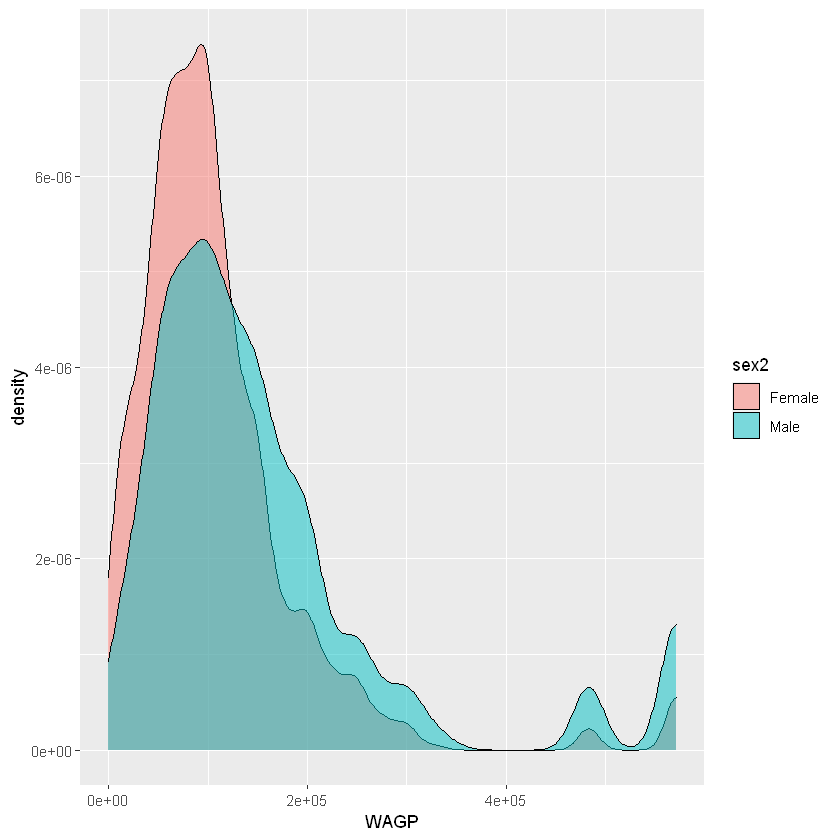

In [8]:
census_sub%>%
    ggplot(mapping = aes(fill=sex2, group=sex2, x=WAGP))+
    geom_density(alpha=.5) #alpha = .5 makes the plots semi-transparent

### Box and whisker plots

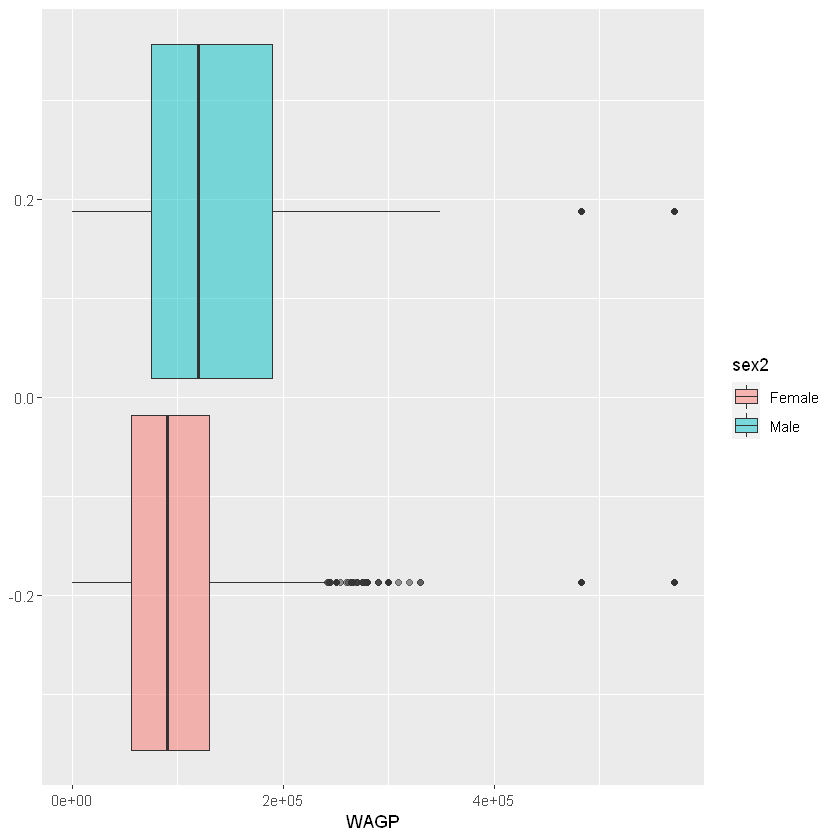

In [9]:
census_sub%>%
    ggplot(mapping = aes(fill=sex2, group=sex2, x=WAGP))+
    geom_boxplot(alpha=.5)

### Create a race-ethnicity recoded variable.
The Census asks separate questions about race and Hispanic/Latino ethincity, so if you want to combine them you have to use two variables, the race variable **RAC1P** and the Hispanic origin varialbe **HISP**. Below is *one way* to do this, where if a person responds as any Hispanic origin, we code them as Hispanic, and combine this with the race variable.

In the ADRF you may need to recode one or more survey variables in order to appropriately represent some of the data. 

In [10]:
census_sub<-census_sub%>%
        # First code Hispanic ethnicty and recode RAC1P into fewer groups
    mutate(hisp = Recode(as.numeric(HISP),
                         recodes = " 2:24='Hispanic'; 1='NonHispanic'",
                         as.factor=T), 
           race_recode = Recode(RAC1P,
                                recodes = "1='White'; 2='Black'; 3='Other'; 4:6='Asian'; 7:9='Other'",
                                as.factor=T))%>%
        # Combine these two using paste()
    mutate(race_eth = paste(hisp, race_recode, sep = "_"))%>%
        #use substr() to see if the first 8 characters of the value == Hispanic
    mutate(race_eth  = as.factor(ifelse(substr(as.character(race_eth),1,8) == "Hispanic",
                                        yes = "Hispanic",
                                        no = as.character(race_eth))))%>%
        #Relevel the factor with nonHispanic whites as the reference level
    mutate(race_eth = relevel(race_eth, ref = "NonHispanic_White"))

Now we can use this variable to do comparisons.

Also shown in this code chunk is how to get the number of observations used to calculate the median in this case. This is important, and in the ADRF you will need to ensure your sample size follows certain minimums in your calculations and output.

This first example uses the original **RAC1P** variable

In [11]:
census_sub%>%
    group_by(RAC1P)%>%
    summarize(median_inc  = median(WAGP), 
             n_obs = n())

RAC1P,median_inc,n_obs
<dbl>,<dbl>,<int>
1,100000,3114
2,84000,208
3,58500,4
5,52050,2
6,120000,1579
7,75000,3
8,90000,93
9,98500,134


We see that codes 3, 5, and 7 have very small numbers, and may compromise the identity of these individuals. If we use our recoded **race_eth** variable, we have combined some of these smaller groups into more statistically valid groups. 

In [12]:
census_sub%>%
    group_by(race_eth)%>%
    summarize(median_inc  = median(WAGP), 
             n_obs = n())

race_eth,median_inc,n_obs
<fct>,<dbl>,<int>
NonHispanic_White,103000,2818
Hispanic,90000,413
NonHispanic_Asian,120000,1577
NonHispanic_Black,84000,206
NonHispanic_Other,100000,123


In [13]:
Now we can make a plot of these summaries

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: Now we
        ^


In [ ]:
census_sub%>%
   group_by(race_eth)%>%
    summarize(median_inc  = median(WAGP))%>% 
ggplot(mapping = aes(fill=race_eth,x=race_eth, y=median_inc))+
    geom_col()+
    theme(axis.text.x=element_text(angle =-45)) #angle the labels

### <span style="color:red">Homework Assignment</span>
Using the above as an example, your **homework** is to create a boxplot, a density plot of the wage variable used above for the two different states to see how PhD wages differ between Texas and California, using the **ST** variable.

#### Saving your output
To save your output, after you run your code and are happy with it, in Jupyter, choose File>Download As, and HTML to create a file with your analysis in it.

1) Calculate the **average wage** for both states and report it

2) Make a bar chart of the **average wage** in both states

3) Make a histogram of the wage distributions in both states

4) Make a box and whisker plot for wage distributions in both states

In general, think about what the differences are between the two states. What do you think this might represent? 

If you're really feelling like a challenge, you can go to the [Census FTP site](https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/) and download a different state's data **(note person files start with `csv_p` and household files start with `csv_h`, you want person-level files**) and re-do this analysis on a different state altogether. 